## Simple RAG playground

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
# os.environ["OPENAI_API_KEY"] = "your-api-key"
PROJECT_ID = "1b35d9bf94ff801792bfd1824fac0c96"
NOTION_TOKEN = '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'

## Customer support Agent

In [3]:
from src import agent

/opt/homebrew/Caskroom/miniforge/base/envs/random/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
response = await agent.ask("Can i get a refund for my missed flight?")
print(response)

Whether you can get a refund for a missed flight depends on the reason for missing it and the fare conditions of your ticket:

1. **Airline-Initiated Cancellations**: If you missed your flight due to an airline-initiated cancellation (e.g., flight delay or cancellation), you could request a full refund.

2. **Passenger-Initiated Reasons**: If you missed your flight due to personal reasons (e.g., arriving late to the airport), the possibility of a refund will depend on the fare type you purchased:
   - **Refundable Tickets**: You may be eligible for a full refund or partial refund, depending on the specific circumstances.
   - **Non-Refundable Tickets**: Generally, these tickets do not allow refunds; however, you may be offered travel credit, or you may need to purchase a new ticket.

3. **Process**: If eligible for a refund, you will need to follow the procedures outlined in the airline's cancellation policy. You may need to provide documentation of your flight and payment details.

4.

## Setup sdk

In [10]:
from ragas_annotator.project.core import Project

In [14]:
project = Project(
    name="Customer support RAG", 
    notion_api_key=NOTION_TOKEN, 
    notion_root_page_id=PROJECT_ID,
)
project

Project(name='Customer support RAG', root_page_id=1b35d9bf94ff801792bfd1824fac0c96)

## Read dataset

In [15]:
from ragas_annotator.model.notion_model import NotionModel
from ragas_annotator import nmt

class Dataset(NotionModel):
    id: str = nmt.ID()
    query: str = nmt.Title()
    expected_answer: str = nmt.Text()

In [16]:
dataset = project.get_dataset(
    name="RAG Dataset",
    model=Dataset,
)
dataset.load()

In [17]:
len(dataset)

15

In [18]:
dataset[0]

Dataset(id=15 query='Are there any special policies for traveling with infants?' expected_answer='Infants under 2 years can travel on an adult’s lap for free or with a discounted seat. Free checked baggage allowance may apply depending on the airline.')

## LLM as judge

In [19]:
from ragas_annotator.llm import ragas_llm
from ragas_annotator.metric import DiscreteMetric
from openai import AsyncOpenAI

llm = ragas_llm(provider="openai",model="gpt-4o",client=AsyncOpenAI())

my_metric = DiscreteMetric(
    llm=llm,
    name='correctness',
    prompt="Evaluate if given answer {response} is same as expected answer {expected_answer}",
    values=["pass","fail"],
)

    
# test LLM as judge
result = my_metric.score(response="this is my response",expected_answer="this is not my response")
result

'fail'

### Writing custom logic with metric (optional)

In [ ]:
# #| eval: false
# @discrete_metric(llm=llm,
#     prompt="Evaluate if given answer is helpful\n\n{response}",
#     name='new_metric',
#     values=["low","med","high"]
#     )
# def my_metric(llm,prompt,example_store, **kwargs):

#         class response_model(BaseModel):
#              output: t.List[bool]
#              reason: str
        
#         response = llm.generate(
# 	        prompt.format(**kwargs),response_model=response_model
# 	      )
#         total = sum(response.output)
#         if total < 1:
#             score = 'low'
#         else:
#             score = 'high'
#         return score,"reason",

# result = my_metric.score(response='my response') # result
# print(result)
# print(result.reason)

## Exp - 1

In [24]:
import typing as t
class Experiment(Dataset):
    response: str = nmt.Text()
    correctness: t.Literal['pass','fail'] = nmt.Select()
    correctness_reason: str = nmt.Text()
    


In [26]:
import json

@project.langfuse_experiment(Experiment, name_prefix="Workshop")
async def run_experiment(row: Dataset):
    response = await agent.ask(row.query)
    score = await my_metric.ascore(response=response, expected_answer=row.expected_answer)

    experiment_view = Experiment(
        id=row.id,
        query=row.query,
        expected_answer=row.expected_answer,
        response=response,
        correctness=score.result,
        correctness_reason=score.reason,
    )
    
    return experiment_view

In [27]:
await run_experiment.run_async(
    name="my-experiment-sad",
    dataset=dataset
)

100%|████████████████████| 15/15 [00:13<00:00,  1.14it/s]


Experiment(name=my-experiment-1111, model=Experiment)

### Train LLM as judge

In [28]:
experiment_data = project.get_experiment('my-experiment-1111',Experiment)

In [29]:
experiment_data.load()

In [31]:
from ragas_annotator.embedding import ragas_embedding

from openai import OpenAI
embedding = ragas_embedding(provider='openai',client=OpenAI(),model="text-embedding-3-small")


In [32]:
my_metric.train(project,experiment_names=['my-experiment-1111'],embedding_model=embedding,model=Experiment,method={})

Processing examples: 100%|█| 15/15 [00:00<00:00, 115651.7


### Compare experiments

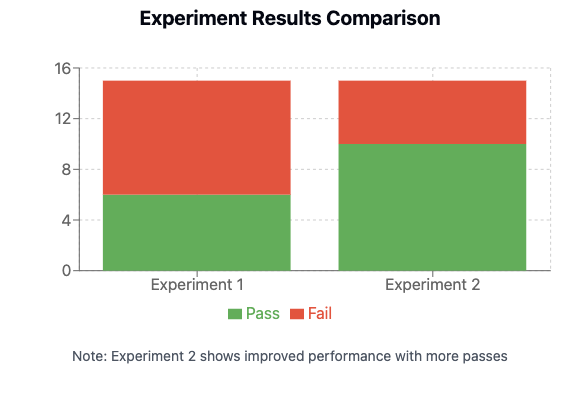

In [33]:
from IPython.display import Image, display

# Display image
display(Image('/Users/shahules/Downloads/comparison-image.png'))  # Update this path